In [200]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn

<Figure size 432x288 with 0 Axes>

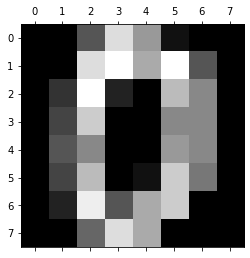

In [201]:
from sklearn.datasets import load_digits
digits = load_digits()
#print(digits.data.shape) #(1797, 64)
#digits.image.shape #(1797, 8,8)
#print(digits.keys()) #dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [202]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split  #train_test_split 默认 shuffle 数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)
digits.target[:10],y_train[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([8, 7, 1, 4, 6, 2, 8, 7, 5, 9]))

## 半监督学习
将训练集分成50个集群，找到每个离质点最近的图像作为代表

先随机取50个 - 观察训练效果

In [203]:
k = 50
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100, random_state=42)
log_reg.fit(X_train[:k],y_train[:k])
log_reg.score(X_test, y_test)

/Users/rmbp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8166666666666667

手动标记选取具有代表性的50个数据

In [204]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = k, random_state=42)
dist_to_centers = kmeans.fit_transform(X_train,y_train) #距离每个样本各自距离50个团簇的的距离
dist_to_centers.shape

(1257, 50)

In [205]:
closest_to_centers_index = np.argmin(dist_to_centers,axis=0)  # 距离每个团簇最近样本的index
closest_to_centers_index[:10], closest_to_centers_index.shape

(array([ 475,  751,  256,  166,   69,  772, 1221,  601,  130,   56]), (50,))

In [206]:
# 选取代表性的50个数据训练
X_train_repre_50 = X_train[closest_to_centers_index]
y_train_repre_50 = y_train[closest_to_centers_index]
log_reg.fit(X_train_repre_50, y_train_repre_50)
log_reg.score(X_test, y_test)

/Users/rmbp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9055555555555556

将同一团簇的打上相同的标签，然后进行训练

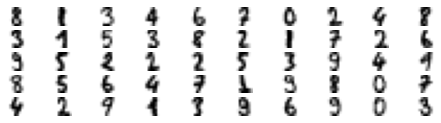

In [207]:
X_train_repre_50_image = X_train_repre_50.reshape(-1,8,8)
plt.figure(figsize=(8,2))
index=1
for each_image in X_train_repre_50_image:
    plt.subplot(5,10,index)
    plt.imshow(each_image, cmap="binary", interpolation="hamming")
    plt.axis("off")
    index += 1
plt.show()

In [208]:
y_real_labels = [8,1,3,4,6,7,0,2,4,8,
                3,1,5,3,8,2,1,7,2,6,
                9,5,2,2,2,5,3,9,4,9,
                8,5,6,4,7,1,9,8,0,7,
                4,2,9,1,3,9,6,9,0,3]   # 50个团簇所代表的真实标签
y_train_propagated = np.empty((len(X_train),1))
samples_to_closest_samples = np.argmin(dist_to_centers,axis=1)
for index,y_real_label in enumerate(y_real_labels):
    y_train_propagated[samples_to_closest_samples==index] = y_real_label
    
#y_train_propagated = np.empty((len(X_train),1))
#for index,y_real_label in enumerate(y_real_labels):
    #y_train_propagated[kmeans.labels_==index] = y_real_label

In [209]:
log_reg.fit(X_train,y_train_propagated)
log_reg.score(X_test,y_test)

/Users/rmbp/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rmbp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9166666666666666

选定每个簇的离中心最近的前10%作为训练数据


np.percentile

In [210]:
arr = np.array([[3,2,1],[4,3,1]])
np.percentile(arr,10,axis=1), np.percentile(arr,20,axis=0) 

(array([1.2, 1.4]), array([3.2, 2.2, 1. ]))

In [211]:
cluster_dist = np.min(dist_to_centers,axis=1)
percent_to_choice = 10
for index in range(k):
    current_cluster_index = kmeans.labels_==index
    current_cluster_data = cluster_dist[current_cluster_index]
    threshold = np.percentile(current_cluster_data, percent_to_choice)
    cluster_dist[current_cluster_index & (cluster_dist>threshold)] = -1

X_train_percent10 = X_train[cluster_dist != -1]
y_train_percent10 = y_train[cluster_dist != -1]
log_reg1 = LogisticRegression(max_iter=100, random_state=42)
log_reg1.fit(X_train_percent10, y_train_percent10)
print("logistic:",log_reg1.score(X_test,y_test))

logistic: 0.9407407407407408


/Users/rmbp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
